In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd # used to load, manipulate the data and for one-hot encoding
import numpy as np # data manipulation
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample # for downsample the dataset
from sklearn.model_selection import train_test_split # for splitting the dataset into train and test split
from sklearn.preprocessing import scale # scale and center the data
from sklearn.svm import SVC # will make a SVM for classification
from sklearn.model_selection import GridSearchCV # will do the cross validation
from sklearn.metrics import plot_confusion_matrix # will draw the confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv
/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv


In [2]:
data = pd.read_csv("../input/mri-and-alzheimers/oasis_longitudinal.csv")
pd.set_option('display.max_columns', None) # will show the all columns with pandas dataframe
pd.set_option('display.max_rows', None) # will show the all rows with pandas dataframe

In [3]:
data.head(10)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


In [4]:
data['M/F'] = data['M/F'].replace("F", 0)
data['M/F'] = data['M/F'].replace("M", 1)

data['Group'] = data['Group'].replace("Nondemented", 0)
data['Group'] = data['Group'].replace("Demented", 1)
data['Group'] = data['Group'].replace("Converted", 1)

In [5]:
data['MMSE'].fillna(data['MMSE'].median(), inplace=True)
data['SES'].fillna(data['SES'].median(), inplace=True)

In [6]:
data.head(20)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,0,1,0,1,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0,2,457,1,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1,1,0,1,R,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1,2,560,1,R,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1,3,1895,1,R,80,12,2.0,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,0,1,0,0,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,0,2,538,0,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,0,1,0,1,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,0,2,1010,1,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,0,3,1603,1,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


In [7]:
correlation_matrix = data.corr()
data_corr = correlation_matrix['Group'].sort_values(ascending=False)
data_corr

Group       1.000000
CDR         0.778049
M/F         0.222146
SES         0.038870
ASF         0.032495
Age        -0.005941
eTIV       -0.042700
Visit      -0.095507
MR Delay   -0.120638
EDUC       -0.193060
nWBV       -0.311346
MMSE       -0.520553
Name: Group, dtype: float64

In [8]:
y = data['Group'].values
X = data[['CDR', 'M/F', 'MMSE', 'nWBV','EDUC']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size= 0.20, random_state=42)
df_ytrain = pd.DataFrame(y_trainval)
df_ytest = pd.DataFrame(y_test)

Train accuracy  0.7785234899328859
Test accuracy  0.6933333333333334
Test recall 0.5116279069767442
Test AUC 0.7245639534883721


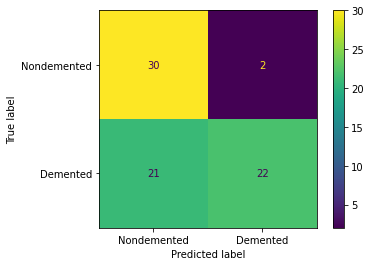

In [9]:
#Support Vector Machine
clf_svm = SVC(random_state=42)
clf_svm.fit(X_trainval, y_trainval)

train_score = 0
test_score = 0
test_recall = 0
test_auc = 0

train_score = clf_svm.score(X_trainval, y_trainval)
test_score = clf_svm.score(X_test, y_test)
y_predict = clf_svm.predict(X_test)

test_recall = recall_score(y_test, y_predict)
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(svm_fpr, svm_tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)
# for test there are 94 cases
plot_confusion_matrix(clf_svm, 
                      X_test, 
                      y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

Train accuracy  0.9630872483221476
Test accuracy  0.88
Test recall 0.813953488372093
Test AUC 0.8913517441860466


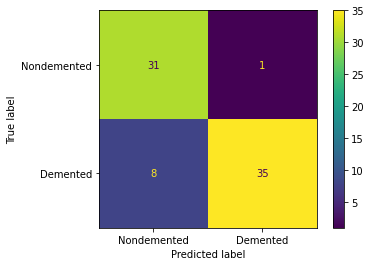

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc

log_reg_model = LogisticRegression().fit(X_trainval, y_trainval)

train_score = 0
test_score = 0
test_recall = 0
test_auc = 0
log_reg_model = LogisticRegression().fit(X_trainval, y_trainval)
train_score = log_reg_model.score(X_trainval, y_trainval)
test_score = log_reg_model.score(X_test, y_test)
scores = log_reg_model.score(X_test, y_test)
y_predict = log_reg_model.predict(X_test)
test_recall = recall_score(y_test, y_predict)
lgr_fpr, lgr_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(lgr_fpr, lgr_tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

# for test there are 94 cases
plot_confusion_matrix(log_reg_model, X_test, y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

Train accuracy: 1.0
Test accuracy: 0.8933333333333333
Test recall: 0.8372093023255814
Test AUC: 0.9029796511627908


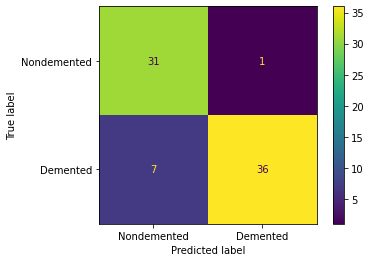

In [11]:
dt_model = DecisionTreeClassifier().fit(X_trainval, y_trainval)

train_score = 0
test_score = 0
test_recall = 0
test_auc = 0
dt_model = DecisionTreeClassifier().fit(X_trainval, y_trainval)
train_score = dt_model.score(X_trainval, y_trainval)
test_score = dt_model.score(X_test, y_test)
y_predict = dt_model.predict(X_test)
test_recall = recall_score(y_test, y_predict)
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(dt_fpr, dt_tpr)

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print("Test recall:", test_recall)
print("Test AUC:", test_auc)

# for test there are 94 cases
plot_confusion_matrix(dt_model, X_test, y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

Train accuracy  1.0
Test accuracy  0.88
Test recall 0.8372093023255814
Test AUC 0.8873546511627908


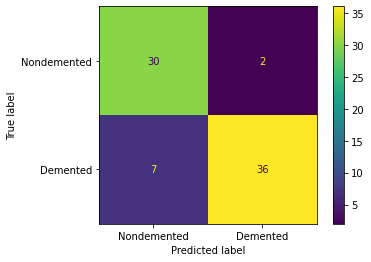

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_trainval, y_trainval)

train_score = 0
test_score = 0
test_recall = 0
test_auc = 0
train_score = rfc.score(X_trainval, y_trainval)
test_score = rfc.score(X_test, y_test)
y_predict = rfc.predict(X_test)
test_recall = recall_score(y_test, y_predict)
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, y_predict)
test_auc = auc(rfc_fpr, rfc_tpr)

print("Train accuracy ", train_score)
print("Test accuracy ", test_score)
print("Test recall", test_recall)
print("Test AUC", test_auc)

# for test there are 94 cases
plot_confusion_matrix(rfc, X_test, y_test, 
                      values_format='d', 
                      display_labels=['Nondemented', 'Demented'])

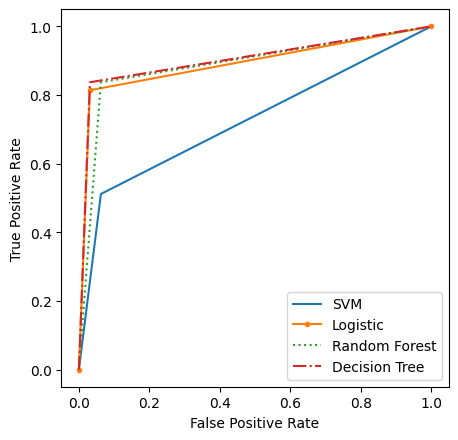

In [13]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM')
plt.plot(lgr_fpr, lgr_tpr, marker='.', label='Logistic')
plt.plot(rfc_fpr, rfc_tpr, linestyle=':', label='Random Forest')
plt.plot(dt_fpr, dt_tpr, linestyle='-.', label='Decision Tree')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

In [14]:
print(data.columns)

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')


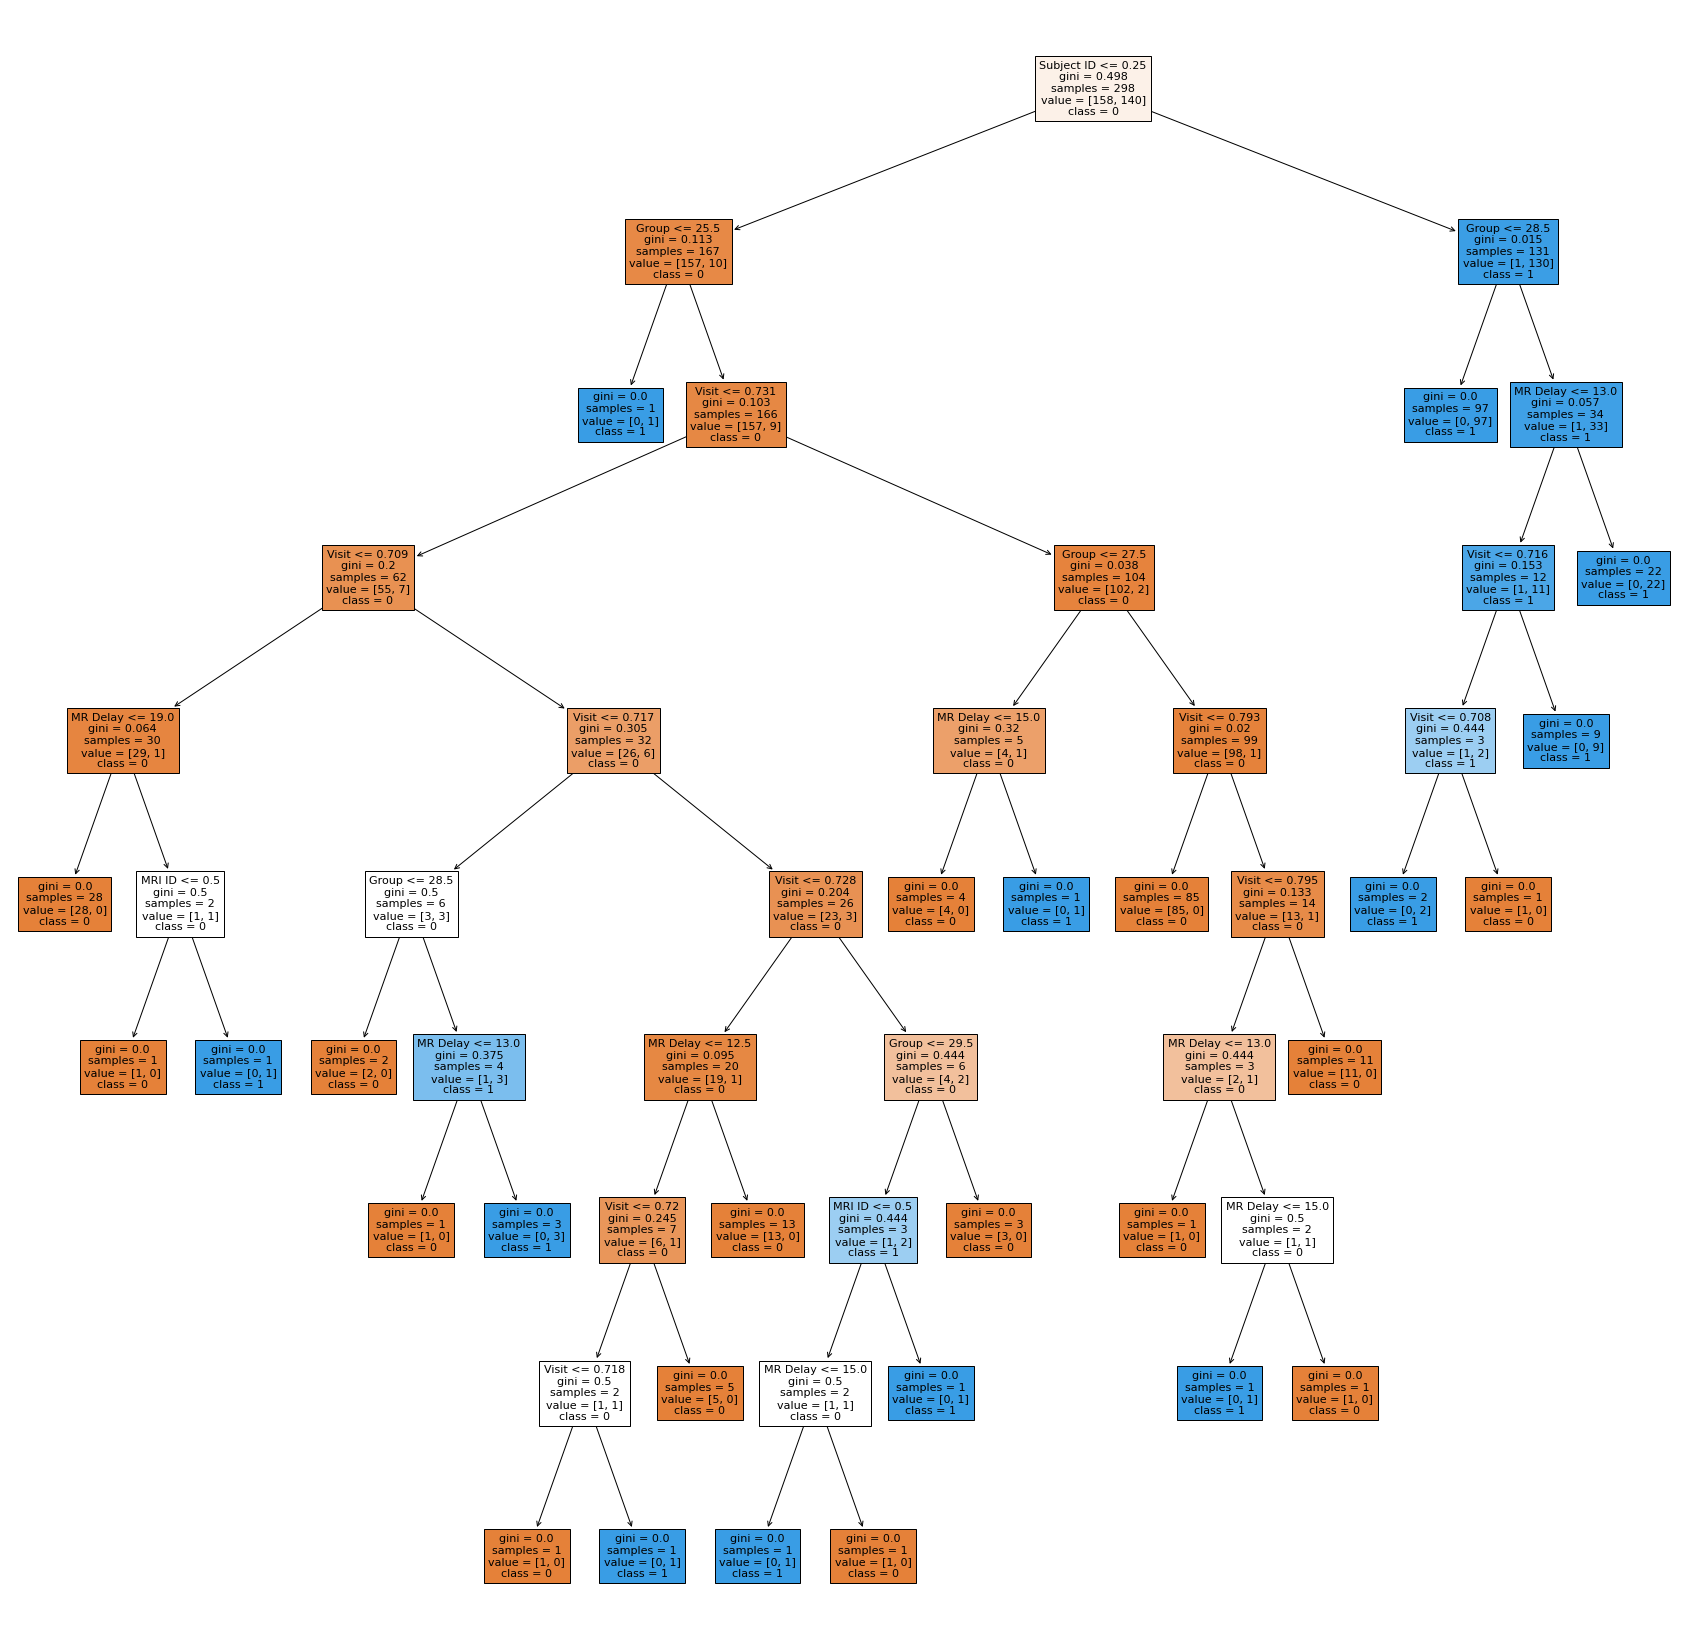

In [15]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

fig = plt.figure(figsize=(30,30))
tree.plot_tree(dt_model, feature_names=data.columns,class_names=['0','1'],filled=True)
fig.savefig("decistion_tree.png")